In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive as inp 
from IPython.display import display

In [2]:
#input parameters
def InputParameters(R=0.1, L=2e-7, G=0.0, C=100e-12, l=1.0, f=1e9, ZL_real=50.0, ZL_imag=20.0):
    global Rg,Lg,Gg,Cg,lg,fg,ZLg
    Rg,Lg,Gg,Cg,lg,fg = R,L,G,C,l,f
    ZLg=complex(ZL_real,ZL_imag)
    print("Line Parameters:")
    print(f"R={R}, L={L}, G={G}, C={C}, l={l}, f={f}, ZL={ZLg}")
parameters = inp(InputParameters,R=(0,1,0.01), L=(1e-9,1e-6,1e-9), G=(0,1,0.01), C=(1e-12,1e-9,1e-12),l=(0.1,10,0.1), f=(1e6,10e9,1e6), ZL_real=(0,200,1), ZL_imag=(-100,100,1))
display(parameters)


interactive(children=(FloatSlider(value=0.1, description='R', max=1.0, step=0.01), FloatSlider(value=2e-07, de…

In [3]:
#Calculate Constants
global Omega,Gamma,Alpha,Beta,Zo,Vp,Lambda
Omega = 2*np.pi*fg 
Gamma = np.sqrt((Rg + 1j*Omega*Lg)*(Gg + 1j*Omega*Cg))
Alpha = np.real(Gamma)
Beta = np.imag(Gamma)
Zo = np.sqrt((Rg + 1j*Omega*Lg)/(Gg + 1j*Omega*Cg))
Vp = Omega/Beta
Lambda = (2*np.pi)/Beta
Alpha, Beta, Zo, Vp, Lambda


(np.float64(0.0011180339878648908),
 np.float64(28.099258946405484),
 np.complex128(44.72135958539596-0.001779406357134415j),
 np.float64(223606797.57297814),
 np.float64(0.22360679757297813))

In [4]:
#Reflection and Matching
global RC ,SWR,Zin
RC = (ZLg-Zo)/(ZLg+Zo)
SWR = (1 + np.abs(RC))/(1-np.abs(RC))
Zin = Zo * ((ZLg + 1j*Zo*np.tan(Beta*Lg))/(Zo + 1j*ZLg*np.tan(Beta*Lg)))
RC,SWR,Zin

(np.complex128(0.09603006530220015+0.19088988012804634j),
 np.float64(1.5435056820985253),
 np.complex128(50.000251348464765+19.999987442019393j))

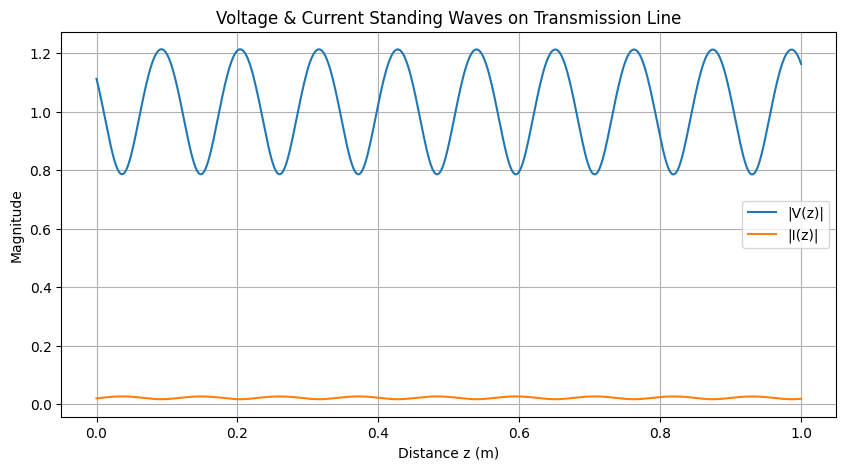

Z0 = (44.72135958539596-0.001779406357134415j)
Load ZL = (50+20j)
Reflection coeff Γ = (0.09603006530220015+0.19088988012804634j)
 |Γ| = 0.21368369094819736
SWR = 1.5435056820985253
V max, V min = 1.213558206000386 0.785747119831945
Vmax/Vmin = 1.544464084398987
I forward approx = 0.02236067973959773
I magnitudes (example) = 0.02713751293677609 0.01756666355485905


In [5]:
#Plotting Graphs
global Vo_Plus, Vo_Minus, z, Vz, Iz
Vo_Plus = 1
Vo_Minus = RC*Vo_Plus
z = np.linspace(0,lg,500)
Vz = Vo_Plus * np.exp(-Alpha*z) * np.exp(-1j*Beta*z) \
     + Vo_Minus * np.exp(-Alpha*z) * np.exp(1j*Beta*z)
Iz = (Vo_Plus/Zo) * np.exp(-Alpha*z) * np.exp(-1j*Beta*z) \
     - (Vo_Minus/Zo) * np.exp(-Alpha*z) * np.exp(1j*Beta*z)

plt.figure(figsize=(10,5))
plt.plot(z, np.abs(Vz), label="|V(z)|")
plt.plot(z, np.abs(Iz), label="|I(z)|")
plt.xlabel("Distance z (m)")
plt.ylabel("Magnitude")
plt.title("Voltage & Current Standing Waves on Transmission Line")
plt.legend()
plt.grid(True)
plt.show()
print("Z0 =", Zo)
print("Load ZL =", ZLg)           
print("Reflection coeff Γ =", RC) 
print(" |Γ| =", abs(RC))
print("SWR =", (1+abs(RC))/(1-abs(RC)))
print("V max, V min =", np.max(np.abs(Vz)), np.min(np.abs(Vz)))
print("Vmax/Vmin =", np.max(np.abs(Vz))/np.min(np.abs(Vz)))
print("I forward approx =", abs(Vo_Plus/Zo))
print("I magnitudes (example) =", np.max(np.abs(Iz)), np.min(np.abs(Iz)))

One-way delay = 4.472135958539598 ns
Gamma_L = (0.09603006530220015+0.19088988012804634j)  |ΓL| = 0.21368369094819736
Gamma_S = (0.05572808923371568+1.983258350186813e-05j)  |ΓS| = 0.05572809276273813
Initial forward amplitude V0+ = (0.4721359553831422-9.916291750934065e-06j)


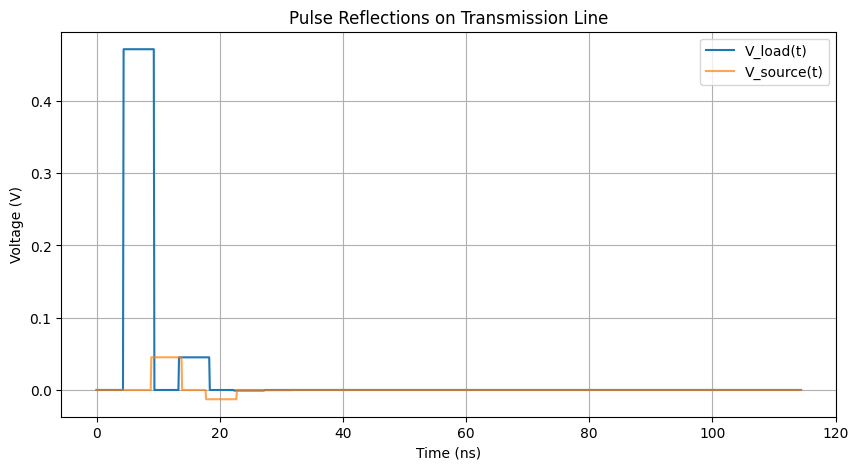

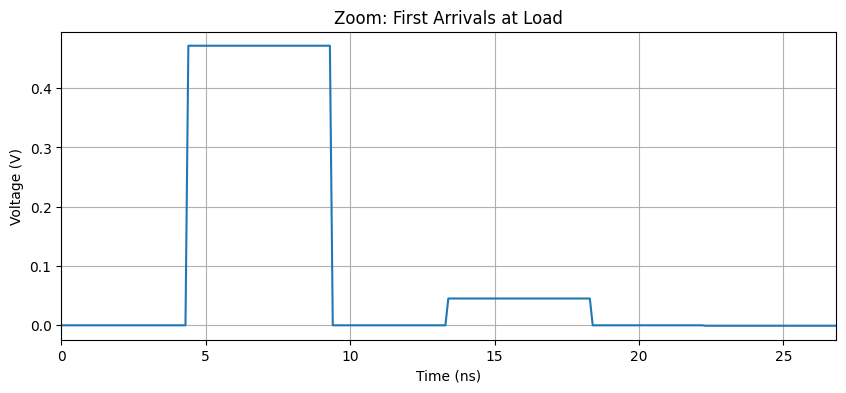

In [6]:
global Vsrc, Zs, pulse_width, n_roundtrips, T_oneway, Gamma_L, Gamma_S, V0_plus
Vsrc = 1.0       
Zs   = 50.0      
pulse_width = 5e-9   
n_roundtrips = 10    

#Derived
T_oneway = lg / Vp        
Gamma_L = RC              
Gamma_S = (Zs - Zo) / (Zs + Zo)   

#Forward amplitude launched onto line
V0_plus = Vsrc * (Zo / (Zs + Zo))

print("One-way delay =", T_oneway*1e9, "ns")
print("Gamma_L =", Gamma_L, " |ΓL| =", abs(Gamma_L))
print("Gamma_S =", Gamma_S, " |ΓS| =", abs(Gamma_S))
print("Initial forward amplitude V0+ =", V0_plus)

#Time axis
max_time = 2 * n_roundtrips * T_oneway + 5 * pulse_width
dt = pulse_width / 50.0
t = np.arange(0, max_time, dt)

#Initialize signals
V_load_t = np.zeros_like(t, dtype=float)
V_source_t = np.zeros_like(t, dtype=float)

#Loop over reflection events
for n in range(n_roundtrips):
    #Arrival at load
    travel_dist_load = (2*n + 1) * lg
    t_arrival_load = travel_dist_load / Vp
    att = np.exp(-Alpha * travel_dist_load)
    A_load = V0_plus * (Gamma_L**n) * (Gamma_S**max(0,n-1)) * att
    idx0 = int(t_arrival_load/dt)
    idx1 = idx0 + int(pulse_width/dt)
    if idx0 < len(t): V_load_t[idx0:idx1] += np.real(A_load)

    #Arrival at source (after reflection back)
    travel_dist_src = (2*n + 2) * lg
    t_arrival_src = travel_dist_src / Vp
    att_src = np.exp(-Alpha * travel_dist_src)
    A_src = V0_plus * (Gamma_L**(n+1)) * (Gamma_S**max(0,n-1)) * att_src
    idx0s = int(t_arrival_src/dt)
    idx1s = idx0s + int(pulse_width/dt)
    if idx0s < len(t): V_source_t[idx0s:idx1s] += np.real(A_src)

#Plot results
plt.figure(figsize=(10,5))
plt.plot(t*1e9, V_load_t, label="V_load(t)")
plt.plot(t*1e9, V_source_t, label="V_source(t)", alpha=0.7)
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")
plt.title("Pulse Reflections on Transmission Line")
plt.legend(); plt.grid(True); plt.show()

#Zoom on first few arrivals at load
plt.figure(figsize=(10,4))
plt.plot(t*1e9, V_load_t, label="V_load(t)")
plt.xlim(0, 6*T_oneway*1e9)
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")
plt.title("Zoom: First Arrivals at Load")
plt.grid(True); plt.show()

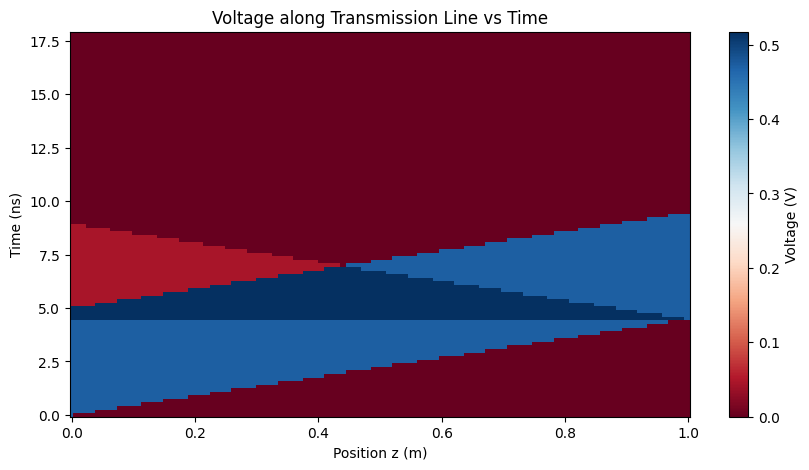

In [7]:
pulse_width = 5e-9
dt = pulse_width / 30.0
t_max = 4 * lg / Vp   
t = np.arange(0, t_max, dt)
z = np.linspace(0, lg, 200)


Vzt = np.zeros((len(t), len(z)))


for i, ti in enumerate(t):
    
    zf = Vp * ti
    
    zr = 2*lg - Vp*ti

    for j, zj in enumerate(z):
        val = 0.0
        
        if 0 <= zf - zj <= Vp*pulse_width:
            val += np.real(V0_plus) * np.exp(-Alpha*zj)
        
        if 0 <= zr - zj <= Vp*pulse_width and ti >= lg/Vp:
            val += np.real(V0_plus*RC) * np.exp(-Alpha*(2*lg - zj))
        Vzt[i, j] = val

#Plot spatio-temporal map
plt.figure(figsize=(10,5))
plt.pcolormesh(z, t*1e9, Vzt, shading='auto', cmap='RdBu')
plt.colorbar(label="Voltage (V)")
plt.xlabel("Position z (m)")
plt.ylabel("Time (ns)")
plt.title("Voltage along Transmission Line vs Time")
plt.show()